In [330]:
os.chdir('/home/mike/Desktop/Word Embeddings')
import os
import pandas as pd
import pickle
from gensim.models import Word2Vec
from random import randint

os.chdir('./Text Processing')
from TextPrep import TextPrep

os.chdir('../Meta Data')
from key_words import key_words, key_synonyms
from stop_words import stop_words
os.chdir('..')

In [331]:
def similar_words(word, model, topn):
    sim_words = []
    for i in range(topn):
        sim_words.append(model.wv.most_similar(word, topn = topn)[i][0])
    return sim_words   

In [332]:
# load in data
meta_data = pd.read_csv('Meta Data/meta_data.csv')
tweet_df = pd.read_csv('Data/aggregated_tweets.csv')
# subset to tweets after oct 29
tweet_df = tweet_df[tweet_df['created'] >= '2019-10-29']
# merge data with meta data
tweet_df = pd.merge(tweet_df, meta_data, how = 'inner', on = 'user_id')
tweet_df = tweet_df[tweet_df.party.isin(['R', 'D'])].reset_index(drop=True)

tweets = tweet_df['text']
labels = tweet_df['party']

# initialize parser
prep = TextPrep(stopwords = stop_words, key_words = key_words, key_synonyms = key_synonyms)

In [333]:
%%time
# preprocess text
tweets = [prep.twitter_preprocess(tweet) for tweet in tweets]

CPU times: user 421 ms, sys: 18 µs, total: 421 ms
Wall time: 420 ms


## Party Labels Trump

In [334]:
%%time
# tag keywords
ptrump_tweets = []
for i in range(len(tweets)):
    try:
        ptrump_tweets.append(prep.tag_keywords('trump', tweets[i], labels[i]))
    except:
        print('failed at '+ str(i))

# lemmatize
ptrump_tweets = prep.multi_lemmatizer(ptrump_tweets, threads = 6)

CPU times: user 1min 10s, sys: 3.21 s, total: 1min 14s
Wall time: 24.4 s


In [351]:
# drop single letters
for i in range(len(ptrump_tweets)):
    ptrump_tweets[i] = [word for word in ptrump_tweets[i] if len(word) > 1]

In [364]:
%%time
# train word2vec
#ptrump_model = Word2Vec(ptrump_tweets, window = 10)

# assign data to variables
rtrump_words = similar_words('trump_r', ptrump_model, topn = 10)
dtrump_words = similar_words('trump_d', ptrump_model, topn = 10)
ptrump_sim = ptrump_similarity = ptrump_model.wv.similarity('trump_r', 'trump_d')

CPU times: user 21.4 ms, sys: 0 ns, total: 21.4 ms
Wall time: 5.52 ms


In [369]:
dtrump_words
# ptrump_sim

['political',
 'wrong',
 'undermine',
 'corruption',
 'corrupt',
 'campaign',
 'pre',
 'interference',
 'clear',
 'try']

In [409]:
[key for key in ptrump_model.wv.vocab]

['not',
 'long',
 'vote',
 'impeachment',
 'inquiry',
 'open',
 'transparent',
 'today',
 're',
 'learn',
 'numerous',
 'closed',
 'deposition',
 'take',
 'place',
 'week',
 'surprising',
 'stoptheschiffshow',
 'look',
 'forward',
 'show',
 'repmarkgreen',
 'fl',
 'amp',
 'introduce',
 'outstanding',
 'veteran',
 'community',
 'florida',
 'yes',
 'resolution',
 'give',
 'stamp',
 'approval',
 'process',
 'damage',
 'repair',
 'watch',
 'floor',
 'speech',
 'morning',
 'impeachmentinquiry',
 'house',
 'formalize',
 'trump_r',
 'clear',
 'democrat',
 'interested',
 'precedent',
 'goal',
 'remove',
 'office',
 'period',
 'dc',
 'team',
 'happy',
 'help',
 'theuso',
 'afternoon',
 'total',
 'care',
 'package',
 'assemble',
 'deployed',
 'service',
 'member',
 'thank',
 'defend',
 'freedom',
 'uso',
 'force',
 'armed',
 'interview',
 'boee',
 'max',
 'hearing',
 'evening',
 'transportgop',
 'step',
 'committee',
 'brief',
 'moment',
 'live',
 'feed',
 'number',
 'legislative',
 'day',
 'lea

In [445]:
pc_df = pd.DataFrame(data = result, columns = ['pc1', 'pc2', 'pc3'])
pc_df['word'] = [key for key in ptrump_model.wv.vocab]
words = rtrump_words[0:5] + ['trump_r'] + dtrump_words[0:5] + ['trump_d']
pc_df = pc_df[pc_df['word'].isin(words)].reset_index(drop=True)

pc_df['label'] = np.where(pc_df['word'].isin(rtrump_words[0:5] + ['trump_r']), "Republican", "Democrat")
pc_df['color'] = np.where(pc_df['label'] == 'Republican', "red", "blue")
pc_df

,pc1,pc2,pc3,word,label,color
0,8.157920,0.076945,1.233560,trump_r,Republican,red
1,8.190639,1.047059,1.282021,political,Democrat,blue
2,8.397344,1.005053,0.263210,trump_d,Democrat,blue
3,3.392665,0.222725,1.047282,confirm,Republican,red
4,5.161929,0.998186,0.727809,impeach,Republican,red
5,3.783914,1.270156,-0.167581,undermine,Democrat,blue
6,4.906528,0.477292,1.948289,corruption,Democrat,blue
7,3.902603,1.010087,0.194010,wrong,Democrat,blue
8,2.826718,0.214188,0.769642,corrupt,Democrat,blue
9,0.332747,-0.887864,-0.087800,wrongdoing,Republican,red


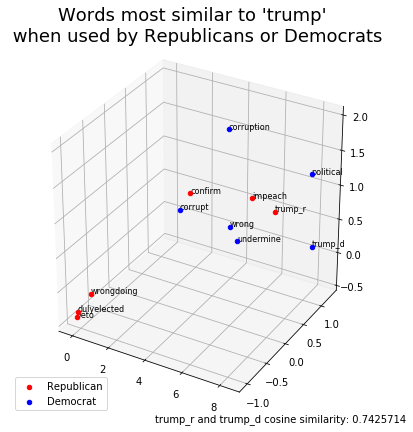

In [493]:
# 3d plot with labels

fig = plt.figure(figsize = [6, 6])
ax = fig.add_subplot(111, projection='3d')

for i in range(len(pc_df['word'])):
    x = pc_df.pc1[i]
    y = pc_df.pc2[i]
    z = pc_df.pc3[i]
    label = pc_df.word[i]
    ax.scatter(x, y, z, color=pc_df.color[i])
    ax.text(x, y, z, '%s' % (label), size=8, zorder=1, color='k')

plt.title('Words most similar to \'trump\' \n when used by Republicans or Democrats', y=1.05, fontsize = 18)
plt.figtext(0.99, 0.01, 'trump_r and trump_d cosine similarity: ' + str(ptrump_sim), horizontalalignment='right')
plt.legend(pc_df.label.unique(), loc = 3)
plt.tight_layout()
plt.savefig('trump_party.png')
plt.show()

## Test with random labels

In [150]:
%%time
# generate random labels
rand_labels = [str(randint(0,1)) for label in labels]

# tag tweets
rand_tweets = []
for i in range(len(tweets)):
    try:
        rand_tweets.append(prep.tag_keywords('trump', tweets[i], rand_labels[i]))
    except:
        print('failed at '+ str(i))

# lemmatize
rand_tweets = prep.multi_lemmatizer(rand_tweets, threads = 6)

CPU times: user 5min 31s, sys: 16.2 s, total: 5min 47s
Wall time: 1min 57s


[['not',
  'long',
  'vote',
  'impeachment',
  'inquiry',
  'open',
  'transparent',
  'today',
  'h',
  're',
  'learn',
  'numerous',
  'closed',
  'deposition',
  'take',
  'place',
  'week',
  's',
  'surprising',
  'stoptheschiffshow'],
 ['look',
  'forward',
  'show',
  'repmarkgreen',
  'fl',
  'week',
  'amp',
  'introduce',
  'outstanding',
  'veteran',
  'community',
  'florida'],
 ['yes',
  'vote',
  'resolution',
  'give',
  'stamp',
  'approval',
  'process',
  'damage',
  'repair',
  'watch',
  'floor',
  'speech',
  'morning',
  'florida',
  'fl',
  'impeachmentinquiry'],
 ['house',
  'vote',
  'resolution',
  'formalize',
  'impeachmentinquiry',
  'trump_1',
  'damage',
  'clear',
  'democrat',
  'interested',
  'precedent',
  'process',
  'goal',
  'remove',
  'trump_1',
  'office',
  'period'],
 ['dc',
  'team',
  'happy',
  'help',
  'theuso',
  'afternoon',
  'total',
  'care',
  'package',
  'assemble',
  'deployed',
  'service',
  'member',
  'thank',
  'defend',

In [152]:
%%time
rand_model = Word2Vec(rand_tweets, window = 10)
rand_model.most_similar('trump_0')
rand_model.most_similar('trump_1')
rand_model.similarity('trump_0', 'trump_1')

CPU times: user 23.3 s, sys: 54.4 ms, total: 23.4 s
Wall time: 10.2 s


## PCA and visualization

In [160]:
rand_model.wv.vocab

{'not': <gensim.models.keyedvectors.Vocab at 0x7fa8c3c7a748>,
 'long': <gensim.models.keyedvectors.Vocab at 0x7fa8c3c7a518>,
 'vote': <gensim.models.keyedvectors.Vocab at 0x7fa8c38a5ac8>,
 'impeachment': <gensim.models.keyedvectors.Vocab at 0x7fa8c38a5ba8>,
 'inquiry': <gensim.models.keyedvectors.Vocab at 0x7fa8c38a5b38>,
 'open': <gensim.models.keyedvectors.Vocab at 0x7fa8c38a5be0>,
 'transparent': <gensim.models.keyedvectors.Vocab at 0x7fa8c38a5c18>,
 'today': <gensim.models.keyedvectors.Vocab at 0x7fa8c38a5c50>,
 'h': <gensim.models.keyedvectors.Vocab at 0x7fa8c38a5c88>,
 're': <gensim.models.keyedvectors.Vocab at 0x7fa8c38a5cc0>,
 'learn': <gensim.models.keyedvectors.Vocab at 0x7fa8c38a5cf8>,
 'numerous': <gensim.models.keyedvectors.Vocab at 0x7fa8c38a5d30>,
 'closed': <gensim.models.keyedvectors.Vocab at 0x7fa8c38a5d68>,
 'deposition': <gensim.models.keyedvectors.Vocab at 0x7fa8c38a5da0>,
 'take': <gensim.models.keyedvectors.Vocab at 0x7fa8c38a5dd8>,
 'place': <gensim.models.keyed

In [167]:
from sklearn.decomposition import PCA


/home/mike/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


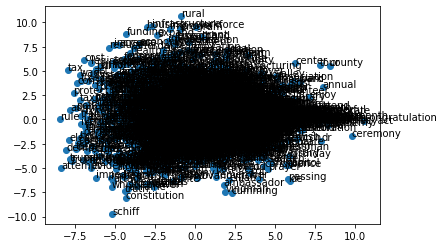

In [181]:
from sklearn.decomposition import PCA
from matplotlib import pyplot
# define training data

# fit a 2d PCA model to the vectors
X = rand_model[rand_model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
# create a scatter plot of the projection
pyplot.scatter(result[:, 0], result[:, 1])
words = list(rand_model.wv.vocab)
for i, word in enumerate(words):
	pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()

In [191]:
rand_model.wv.vocab['trump_0']

/home/mike/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


list

In [230]:
for i in range(5):
    print(i)

0
1
2
3
4


In [231]:
# function to return a list of strings for the most similar words. useful for labeling the scatter plot
def similar_words(word, model, topn):
    sim_words = []
    for i in range(topn):
        sim_words.append(model.most_similar(word, topn = topn)[i][0])
    return sim_words        

In [210]:
trump0_sim_words = []
for i in range(len(rand_model.most_similar('trump_0'))):
    trump0_sim_words.append(rand_model.most_similar('trump_0')[i][0])
    
trump0_sim_words.append('trump_0')
trump0_sim_words

/home/mike/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  
/home/mike/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


['trump_1',
 'obama',
 'president',
 'untenable',
 'blatant',
 'corruption',
 'outrageous',
 'reckless',
 'exactly',
 'corrupt',
 'trump_0']

In [218]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [211]:
# subset the model to only the key word plus the most similar words
sub_rand_model = [rand_model[word] for word in trump0_sim_words]

/home/mike/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [251]:
result[0]

array([-5.2333336, -1.8067499], dtype=float32)

In [254]:
result.explained_variance_

AttributeError: 'numpy.ndarray' object has no attribute 'explained_variance_'

/home/mike/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


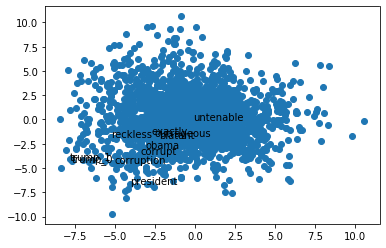

In [262]:
# 2d plot with labels
pca = PCA(n_components=2)
result = pca.fit_transform(rand_model[rand_model.wv.vocab])
# create a scatter plot of the projection
pyplot.scatter(result[:, 0], result[:, 1])

for i, word in enumerate(rand_model.wv.vocab):
    if word in trump0_sim_words:
        pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()

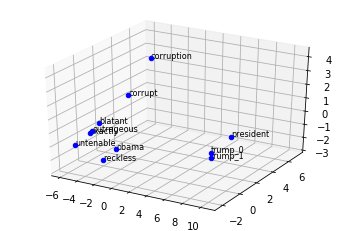

In [229]:
# 3d plot with labels
pca = PCA(n_components=3)
result = pca.fit_transform(sub_rand_model)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i, word in enumerate(trump0_sim_words):
    x = result[i,0]
    y = result[i,1]
    z = result[i,2]
    label = word
    ax.scatter(x, y, z, color='b')
    ax.text(x, y, z, '%s' % (label), size=8, zorder=1, color='k')

plt.show()

In [270]:
pca.explained_variance_ratio_

array([0.11879037, 0.10206051, 0.07979332], dtype=float32)

/home/mike/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


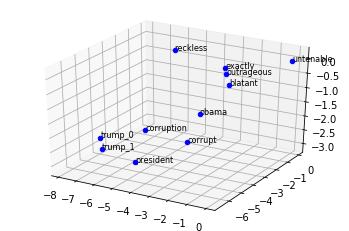

In [267]:
# 3d plot with labels
pca = PCA(n_components=3)
result = pca.fit_transform(rand_model[rand_model.wv.vocab])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i, word in enumerate(rand_model.wv.vocab):
    if word in trump0_sim_words:
        x = result[i,0]
        y = result[i,1]
        z = result[i,2]
        label = word
        ax.scatter(x, y, z, color='b')
        ax.text(x, y, z, '%s' % (label), size=8, zorder=1, color='k')

plt.show()